# Copper grains classification based on thermal images

This demo shows construction and usage of neural network that classifies copper grains.
The grains are recorded with a thermal camera using active thermovision approach.
The network is fed with numbers of low emissivity spots on every stage of cooling down the grain samples.
For more information about tracking and counting these spots refer to other Jupyter demos.

In [34]:
from inspect import getsource
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from blob_series_tracker import count_blobs_with_all_methods
from img_processing import decode_labels, default_img_set, full_prepare
from neural_network import (default_grain_classifier_model,
                            network_cross_validation)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data preparation

Let's see how a sample image of grains looks like.
First we will load the whole default dataset, then we will choose a sample labeled as E5 class at the beginning of the colling process and show it.

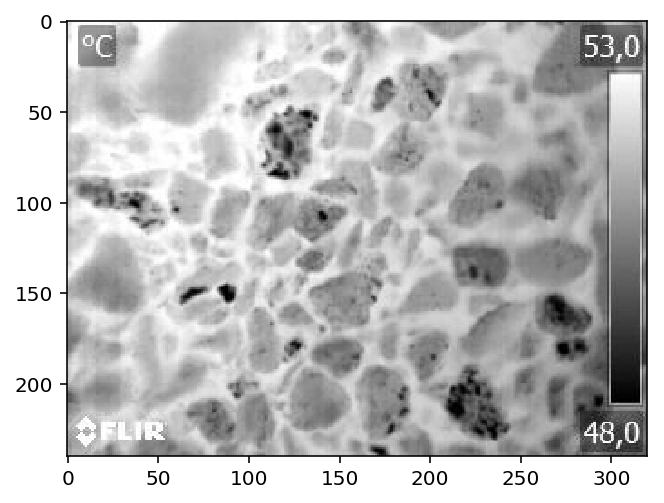

In [35]:
X, y = default_img_set()
plt.imshow(X[0][0]);

Then we should prepare images for classification, they need to be cropped to remove the FLIR UI then they need to be converted to proper grayscale and inverted.
We want to track points with low emissivity that are black spots on the image.
However multiple image processing algorithms treat white spots as foreground features and black space as background.
This is opposite to how colors present temperature on our image so we have to invert the photo.
All these preparations are done by a single function.

In [36]:
X = [[full_prepare(img) for img in same_sample] for same_sample in X]

Then we have to track and count low emissivity blobs on each stage of cooling the grains.
There are three ways of counting the spots:
*  counting all spots at every stage of cooling,
*  tracking blobs that are present from the begging of the cooling and ignoring blobs that appear later,
*  tracking blobs that are present from the begging of the cooling and calculating the ratio of remaining blobs to their    initial number.

To inspect how these methods work relate to other Jupyter demos.
In this notebook we will simply use a function that uses every one of these approaches and compare results.

In [37]:
Xs = count_blobs_with_all_methods(X)

## Classification

We will write a function to classify given grains data.
We have three X datasets, one for every blob counting method.
Later we will call the classification demo function on each of them.

The function turns datasets into NumPy arrays as most of the libraries use this container for computation efficiency.
Then the data is split into train and test sets.
A function from Scikit-learn is used to perform the split.
Notice that the function is given constant random seed to ensure repetitiveness of the demo.
So the call looks like this:
```python
    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.33, random_state=1)
```

### Neural network model

The classifier model is returned by the `default_grain_classifier_model` function.
Let's see what it looks like.

In [38]:
print(getsource(default_grain_classifier_model))

def default_grain_classifier_model():
    '''
    Get default uncompiled model for grain classifcation,
    based on 5 step cooling process using number of blobs.
    '''
    model = keras.Sequential([
        keras.layers.Dense(5, activation='tanh'),
        keras.layers.Dense(256, activation='tanh'),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model



The model has four layers, with two hidden ones.
The number of neurons in the input layer is equal to the size of the input vector, that is five.
If you wish to know why the vector has this size please refer to the other demo notebooks.
The input is equal to the number of classes, in this case it is four.
Outputs of the network represent the probability of the input belonging to each of the classes.
The number of the neurons in hidden layers and their activation functions were chosen based on eperiments.
You can examine the comparison of various network structures in the thesis.

### Network training

The last step of creating a network is the training.
The model compiler has to be given `optimizer`, `loss` and `metrics` parameters that define the training process.
The best loss function that calculates error between output of the network and training label is the `sparse_categorical_crossentropy`.
During comparisons adam optimiser proved to be the best one, as it provides adaptive learning rate.
The comparison of different network training parameters is included in the thesis.

The `classification_demo` function implements the ideas presented above.
It also prints model evaluation on test set and prints training history.

In [39]:
def classification_demo(X, y):
    '''
    Demo grain classification on given data.
    Train and test default model.
    '''
    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.33, random_state=3)

    model = default_grain_classifier_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=400, verbose=0)

    print("Test y:", y_test)
    print("Test y:", [decode_labels(y) for y in y_test])
    print('Test prediction outputs:\n', model.predict(X_test))
    prediction = model.predict_classes(X_test)
    print('Test prediction classification:\n', prediction)
    print('Test prediction classification:\n',
          [decode_labels(y) for y in prediction])
    print('Model evaluation loss and accuracy:\n',
          model.evaluate(X_test, y_test, verbose=0), '\n')

    plt.figure()
    ax = plt.subplot()
    plt.title('Model training history. ' + demo_name)
    plt.xlabel('Epoch')

    lns1 = plt.plot(history.history['accuracy'], c='b', label='Accuracy');
    plt.ylabel('Accuracy')
    plt.twinx()
    lns2 = plt.plot(history.history['loss'], c='r', label='Loss');
    plt.ylabel('Loss')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower right', bbox_to_anchor=(1, 0.5))

## Test results
Now we can use the function to print the results of classification.
The output is rather lengthy, let's break it down.
It prints classes of test set in encoded and decoded form.
Then it shows prediction output for each test.
The closer the output is to one, the more sure the network is that a sample belongs to given class.
Then the predictions are presented in encoded and decoded format.
Each demo is summarized by the loss and accuracy scores.

The method of tracking and calculating ratio of blobs yield the best results.
Not only it has the highest scores, but also the output is more stable.
The first two methods of counting blobs cause the network to give unstable results.
The efficiency vary between each run of the training.
The last method of the data extraction yields the best classes separation which is clearly visible in the evaluation scores.
However this way of validating the classifier is not reliable especially on this extremely small data set.
This way of testing wastes one third of the very limited data set and introduces negative bias to the evaluation.
The better way to validate the network in a more averaged way is presented in other notebook.

All blobs detection
Test y: [3 0 2 1]
Test y: ['E16R', 'E5R', 'E11R', 'E6R']
Test prediction outputs:
 [[4.13094466e-13 9.97023621e-01 2.97637803e-03 9.43214789e-10]
 [9.99783674e-01 1.98215183e-18 7.60494707e-11 2.16326101e-04]
 [9.99566713e-01 3.78670742e-18 6.93438214e-11 4.33287233e-04]
 [9.99331791e-01 6.19646880e-18 6.47325356e-11 6.68208640e-04]]
Test prediction classification:
 [1 0 0 0]
Test prediction classification:
 ['E6R', 'E5R', 'E5R', 'E5R']
Model evaluation loss and accuracy:
 [20.94910975908715, 0.25] 

Detect only remaining blobs
Test y: [3 0 2 1]
Test y: ['E16R', 'E5R', 'E11R', 'E6R']
Test prediction outputs:
 [[2.14621064e-08 3.54349339e-09 9.99930926e-01 6.90491396e-05]
 [9.99713627e-01 5.26648676e-05 2.65711205e-13 2.33707914e-04]
 [1.65281381e-08 8.16690061e-13 8.33264337e-11 9.99999983e-01]
 [2.90208482e-03 4.28318323e-01 5.64522349e-01 4.25724285e-03]]
Test prediction classification:
 [2 0 3 2]
Test prediction classification:
 ['E11R', 'E5R', 'E16R', 'E11R']
Mo

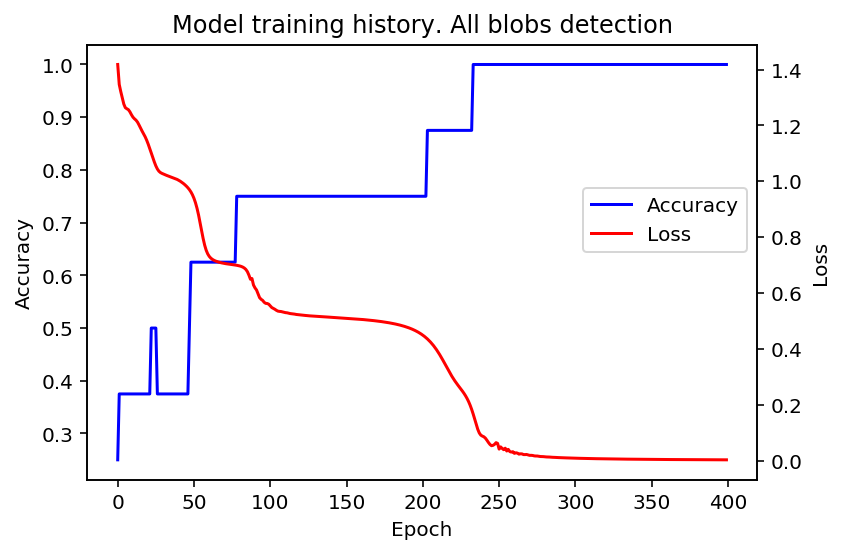

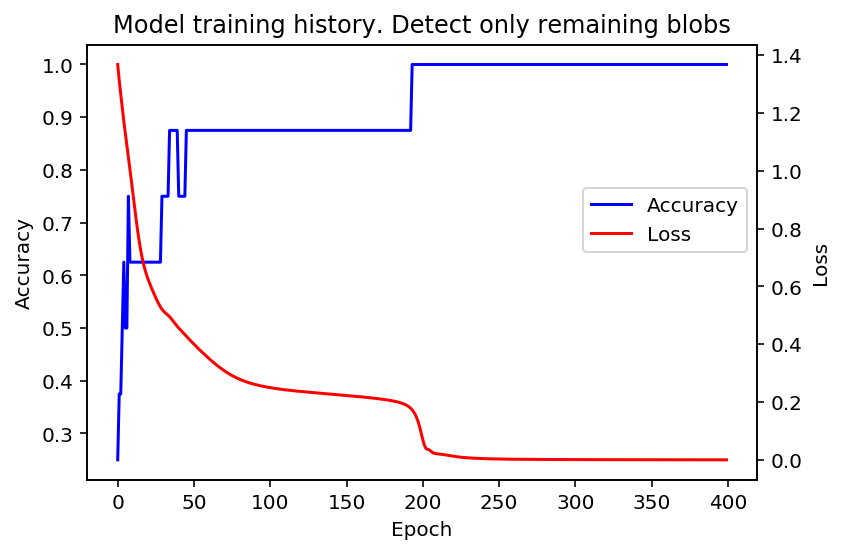

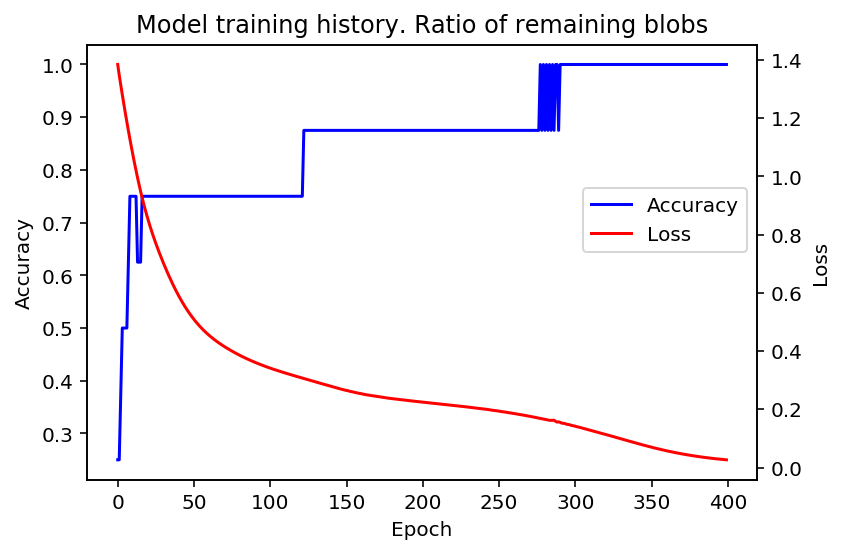

In [40]:
demo_names = ('All blobs detection',
              'Detect only remaining blobs',
              'Ratio of remaining blobs')
for X, demo_name in zip(Xs, demo_names):
    print(demo_name)
    classification_demo(X, y)

# Network validation

The results of the test presented above are not so useful.
The best way to validate the network and check if the idea of grains classification does work is to perform cross validation of the model.
This method splits the data k-times and performs the validation on each split of train and test sets.
The final result of validation is averaged.

Let's crate a function that will validate perform the cross validation for every way of blob counting.

In [41]:
def cross_val_demo(X, y):
    '''Demo cross validation of default grain classifier on given data.'''
    X = np.array(X)
    y = np.array(y)

    model = default_grain_classifier_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    scores = network_cross_validation(model, X, y, 3)

    print('Folds scores: (loss, acc)\n', scores)
    scores = np.array(scores)
    print('Cross validation mean score (loss, acc):\n',
          scores.mean(axis=0), '\n')

The `network_cross_validation` takes the model to test, dataset and number of splits to perform.
We can investigate it's implementation to see how it works.

In [42]:
print(getsource(network_cross_validation))

def network_cross_validation(model, X, y, n_splits):
    '''Compute cross validation fold scores for given keras model.'''
    eval_scores = []

    folds = StratifiedKFold(n_splits=n_splits).split(X, y)
    for train_index, test_index in folds:
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train, y_train, epochs=300, verbose=0)
        eval_scores.append(model.evaluate(x_test, y_test, verbose=0))
    return eval_scores



Now we can perform the validation.
Notice that the accuracy of the last blob tracking method becomes stable 0.92, which is a good result.
It should be chosen as the best way to classify copper grains.
The other methods of data extraction yield poor classification results and should be rejected.

In [43]:
for X, demo_name in zip(Xs, demo_names):
    print(demo_name)
    cross_val_demo(X, y)

All blobs detection
Folds scores: (loss, acc)
 [[2.859358251094818, 0.25], [10.993278554489734, 0.25], [0.13758635614067316, 1.0]]
Cross validation mean score (loss, acc):
 [4.66340772 0.5       ] 

Detect only remaining blobs
Folds scores: (loss, acc)
 [[2.0763888901201426, 0.5], [1.68244448601763, 0.75], [2.5719035755100776, 0.75]]
Cross validation mean score (loss, acc):
 [2.11024565 0.66666667] 

Ratio of remaining blobs
Folds scores: (loss, acc)
 [[0.05480555478061433, 1.0], [4.314720007729477, 0.75], [0.039702661043065746, 1.0]]
Cross validation mean score (loss, acc):
 [1.46974274 0.91666667] 



## Conclusion

The results of the validation proved that the copper grains can be classified using active thermography approach.
The classifier has been tested and trained on a extremely small dataset.
However the results show that the suggested idea is worth further investigation.
The next steps in the project may include creating larger dataset with enhanced measurement stand and development of a more advanced neural network, such as convolutional neural network.